In [25]:
import os
import pickle
from os.path import join
from tifffile import imread
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

from scipy.ndimage import gaussian_filter1d

In [2]:
from ultrack.imgproc import normalize
from ultrack.utils.array import array_apply

In [3]:
cwd = os.getcwd()

In [4]:
cwd

'/mnt/d/DSL/DSL'

In [5]:
file = Path("../Data files/input/4T1 p27 trial period.HTD - Well D02 Field #3.tif")
config_id = 2

In [6]:
experiment = Path(file).stem
parent_dir = Path(file).parent.parent
data_dir = Path(join(parent_dir, "output", experiment))
input_file = Path(join(parent_dir, "input", file.name))

In [7]:
print(experiment, "\n", data_dir,"\n",  input_file)

4T1 p27 trial period.HTD - Well D02 Field #3 
 ../Data files/output/4T1 p27 trial period.HTD - Well D02 Field #3 
 ../Data files/input/4T1 p27 trial period.HTD - Well D02 Field #3.tif


In [8]:
normalized_path = data_dir / "normalized.npy"
cellpose_path = data_dir / "cellpose_labels.npy"
wscp_path = data_dir / "wscp_labels.npy"
stardist_path = data_dir / "stardist_labels.npy"
wssd_path = data_dir / "wssd_labels.npy"
detection_path = data_dir / f"{config_id}" / "detections.npz"
tracks_path = data_dir / f"{config_id}" / "tracks.pkl"
track_label_path = data_dir / f"{config_id}" / "track_labels.npy"
graph_path = data_dir / f"{config_id}" / "graph.pkl"

In [9]:
with open(graph_path, "rb") as f:
    graph = pickle.load(f)

In [10]:
image = imread(input_file)

In [11]:
image = image[:, 1:, :, :]
image = np.swapaxes(image, 1, 3)

In [30]:
# normalized = np.zeros(image.shape, dtype=np.float16)
# array_apply(
#     image,
#     out_array=normalized,
#     func=normalize,
#     gamma=1,
#     axis=(0, 3),
# )

Applying normalize ...: 100%|██████████| 936/936 [00:54<00:00, 17.18it/s]


In [12]:
image.shape

(234, 1024, 1024, 4)

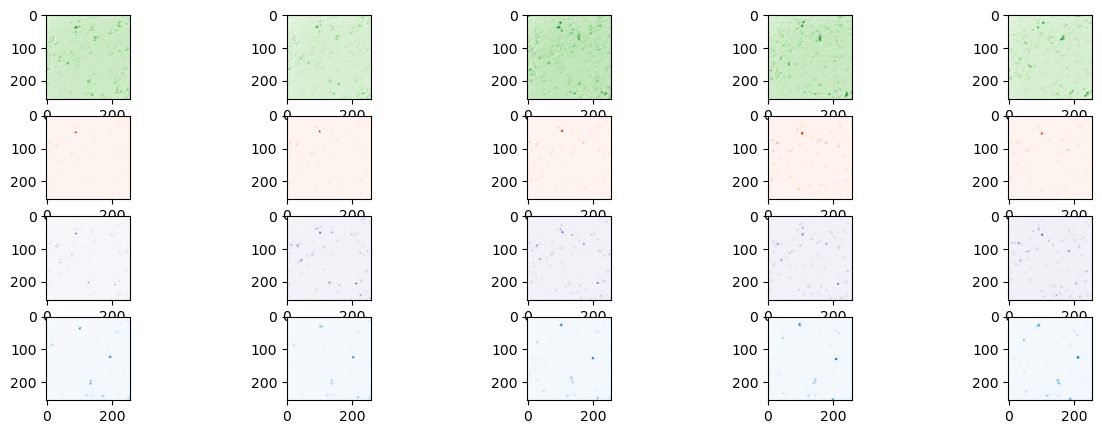

In [13]:
fig, ax = plt.subplots(4, 5, figsize=(15, 5))
for time in range(5):
    ax[0, time].imshow(image[time, :256, :256, 0], cmap="Greens")
    ax[1, time].imshow(image[time, :256, :256, 1], cmap="Reds")
    ax[2, time].imshow(image[time, :256, :256, 2], cmap="Purples")
    ax[3, time].imshow(image[time, :256, :256, 3], cmap="Blues")

In [14]:
tracks_df = pd.read_pickle(tracks_path)

In [15]:
track_labels = np.load(track_label_path)

In [16]:
BLUE_FLAG = (image.shape[1] > 4)

In [17]:
tracks_df.head(10)

,track_id,t,y,x,id,parent_track_id,parent_id
id,,,,,,,
1000021,1,0,13.0,496.0,1000021,-1,-1
2000021,1,1,12.0,497.0,2000021,-1,1000021
3000034,1,2,13.0,498.0,3000034,-1,2000021
4000030,1,3,17.0,496.0,4000030,-1,3000034
5000036,1,4,16.0,499.0,5000036,-1,4000030
6000039,1,5,17.0,492.0,6000039,-1,5000036
7000047,1,6,26.0,492.0,7000047,-1,6000039
8000069,1,7,33.0,493.0,8000069,-1,7000047
9000090,1,8,38.0,492.0,9000090,-1,8000069


In [18]:
def invert_graph(graph):
    inverse_graph = {}
    for key, value in graph.items():
        if value in inverse_graph.keys():
            inverse_graph[value].append(key)
        else:
            inverse_graph[value] = [key]
    return inverse_graph

In [19]:
graph

{2: 1,
 3: 1,
 4: 3,
 5: 4,
 6: 4,
 7: 6,
 8: 6,
 9: 3,
 12: 11,
 13: 11,
 14: 13,
 15: 14,
 16: 15,
 17: 15,
 18: 14,
 19: 13,
 22: 21,
 23: 21,
 24: 23,
 25: 23,
 26: 25,
 27: 26,
 28: 26,
 29: 25,
 31: 30,
 32: 30,
 33: 32,
 34: 32,
 37: 36,
 38: 37,
 39: 37,
 40: 36,
 42: 41,
 43: 41,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 48,
 51: 47,
 52: 51,
 53: 51,
 54: 46,
 55: 54,
 56: 54,
 57: 45,
 58: 44,
 60: 59,
 61: 59,
 62: 61,
 63: 61,
 64: 63,
 65: 63,
 68: 67,
 69: 67,
 70: 69,
 71: 69,
 73: 72,
 74: 72,
 75: 74,
 76: 75,
 77: 76,
 78: 76,
 79: 75,
 80: 74,
 81: 80,
 82: 80,
 84: 83,
 85: 83,
 86: 85,
 87: 86,
 88: 86,
 89: 85,
 93: 92,
 94: 92,
 95: 94,
 96: 94,
 98: 97,
 99: 97,
 104: 103,
 105: 104,
 106: 105,
 107: 105,
 108: 107,
 109: 107,
 110: 104,
 111: 110,
 112: 111,
 113: 111,
 114: 110,
 115: 103,
 116: 115,
 117: 116,
 118: 116,
 119: 118,
 120: 119,
 121: 119,
 122: 118,
 123: 115,
 125: 124,
 126: 125,
 127: 125,
 128: 124,
 129: 128,
 130: 128,
 132: 131,

In [20]:
def get_lines(tracks_df, graph):
    all_tracks = tracks_df["track_id"].unique()

    igraph = invert_graph(graph)

    all_tracks = all_tracks[
        np.isin(all_tracks, np.array(list(graph.keys())), invert=True)
    ]

    def recurse_tracks(all_tracks, parent=None):
        for track_id in all_tracks:
            track = tracks_df[tracks_df["track_id"] == track_id]
            if parent is not None:
                track = pd.concat([parent, track])

            if track_id in igraph.keys():
                yield from recurse_tracks(igraph[track_id], track)
            else:
                yield track

    yield from recurse_tracks(all_tracks)

In [21]:
def get_single_line(track_id, tracks_df, graph):
    for track in get_lines(tracks_df, graph):
        if track_id in track["track_id"].values:
            return track

In [22]:
len(tracks_df)

216803

In [23]:
def populate_cell_intensities(image, track_labels, tracks_df):
    """Get the mean of the intensity of each channel for each track.

    Args:
            image (np.ndarray): numpy array of the image of the shape
                    (time, channels, h, w)
            track_labels (np.ndarray): an numpy array of labels generated
                    by ultrack
            tracks_df (pd.DataFrame): tracks dataframe from ultracks analysis

    Returns:
            pd.DataFrame: tracks dataframe merged with average intensities for
                    each cell
    """
    columns = ["green_intensity", "red_intensity", "farred_intensity"]
    if BLUE_FLAG:
        columns.append("blue_intensity")
    intensities = pd.DataFrame(columns=columns, index=tracks_df.index)

    def compute_intensities(row):
        time = int(row["t"])

        track_mask = track_labels[time] == row["track_id"]
        inten_dict = {
            "green_intensity": np.mean(image[time, :, :, 0][track_mask]),
            "red_intensity": np.mean(image[time, :, :, 1][track_mask]),
            "farred_intensity": np.mean(image[time, :, :, 2][track_mask]),
        }
        if BLUE_FLAG:
            inten_dict["blue_intensity"] = np.mean(image[time, :, :, 3][track_mask])

        return pd.Series(inten_dict)

    intensities = tracks_df.progress_apply(compute_intensities, axis=1)

    tracks_df = pd.merge(tracks_df, intensities, left_index=True, right_index=True)

    return tracks_df

In [24]:
track_intensity_df = populate_cell_intensities(image, track_labels, tracks_df)

  0%|          | 0/216803 [00:00<?, ?it/s]

In [41]:
track_intensity_df.head(10)

,track_id,t,y,x,id,parent_track_id,parent_id,green_intensity,red_intensity,farred_intensity,blue_intensity
id,,,,,,,,,,,
1000021,1,0,13.0,496.0,1000021,-1,-1,892.514019,217.738318,476.560748,530.009346
2000021,1,1,12.0,497.0,2000021,-1,1000021,801.270408,202.397959,476.219388,370.683673
3000034,1,2,13.0,498.0,3000034,-1,2000021,756.716667,286.016667,511.850000,261.950000
4000030,1,3,17.0,496.0,4000030,-1,3000034,707.250000,261.316667,635.983333,259.750000
5000036,1,4,16.0,499.0,5000036,-1,4000030,747.957143,256.114286,500.671429,252.514286
6000039,1,5,17.0,492.0,6000039,-1,5000036,780.666667,256.521739,491.724638,242.086957
7000047,1,6,26.0,492.0,7000047,-1,6000039,728.968421,774.831579,685.842105,249.968421
8000069,1,7,33.0,493.0,8000069,-1,7000047,711.989899,722.373737,610.747475,249.757576
9000090,1,8,38.0,492.0,9000090,-1,8000069,689.346667,813.013333,671.546667,255.946667


In [27]:
def get_intensity_graph(single_intensity_track, smooth = None):
    """Generates a line graph of the intensity of each channel. Also
    indicates when the track was split.
    Note: Locally normalized.

    # TODO: Format graph. Normalize y value (might need to change the function call to do this).

    Args:
            single_intensity_track (pd.DataFrame): a subset of the
                    track_intensity_df which contains a single track line.
                    Must contain intensity columns.
    """
    time = single_intensity_track["t"]
    green_intensity = single_intensity_track["green_intensity"]
    green_intensity = (green_intensity - green_intensity.min()) / (
        green_intensity.max() - green_intensity.min()
    )
    red_intensity = single_intensity_track["red_intensity"]
    red_intensity = (red_intensity - red_intensity.min()) / (
        red_intensity.max() - red_intensity.min()
    )
    farred_intensity = single_intensity_track["farred_intensity"]
    farred_intensity = (farred_intensity - farred_intensity.min()) / (
        farred_intensity.max() - farred_intensity.min()
    )
    if BLUE_FLAG:
        blue_intensity = single_intensity_track["blue_intensity"]
        blue_intensity = (blue_intensity - blue_intensity.min()) / (
            blue_intensity.max() - blue_intensity.min()
        )

    separation_points = []
    lines = single_intensity_track["track_id"].unique()

    for line_idx in lines:
        line = single_intensity_track[single_intensity_track["track_id"] == line_idx]
        if line.iloc[0]["parent_id"] == -1:
            continue
        else:
            separation_points.append(min(line.t))

    fig = plt.figure(figsize=(15, 5))

    if smooth is not None:
        green_intensity_smoothed = gaussian_filter1d(green_intensity, sigma=smooth)
        red_intensity_smoothed = gaussian_filter1d(red_intensity, sigma=smooth)
        farred_intensity_smoothed = gaussian_filter1d(farred_intensity, sigma=smooth)
        if BLUE_FLAG:
            blue_intensity_smoothed = gaussian_filter1d(blue_intensity, sigma=smooth)
        
        plt.plot(time, green_intensity_smoothed, color="green")
        plt.plot(time, red_intensity_smoothed, color="red")
        plt.plot(time, farred_intensity_smoothed, color="purple")
        if BLUE_FLAG:
            plt.plot(time, blue_intensity_smoothed, color="blue")
    
    plt.plot(time, green_intensity, alpha=0.2 if smooth else 1, label="Green", color="green")
    plt.plot(time, red_intensity, alpha=0.2 if smooth else 1, label="Red", color="red")
    plt.plot(time, farred_intensity, alpha=0.2 if smooth else 1, label="Far Red", color="purple")
    if BLUE_FLAG:
        plt.plot(time, blue_intensity, alpha=0.2 if smooth else 1, label="Blue", color="blue")
        
    plt.legend(['Green', 'Red', 'Far Red', 'Blue'])
    top, bottom = plt.ylim()
    plt.vlines(
        separation_points,
        ymin=top,
        ymax=bottom,
        color="black",
    )
    plt.show()

In [35]:
def get_tracking_images(image, track_labels, single_track, padding=10):
    """Gets a list of images of each cell in the track
    for each channel.

    **or**

    Generates a list of images of each cell in the track
    for each channel.

    Args:
            image (np.ndarray): numpy array of the image of the
                    shape (time, channels, h, w)
            single_track (pd.DataFrame): a subset of tracks_df
                    containing a single track line.
    """
    channels = image.shape[3] + 1
    total_time = len(single_track)
    fig, ax = plt.subplots(channels, total_time, figsize=(15, 5))

    for cell in single_track.itertuples():
        time = cell.t

        track_mask_idx = np.where(track_labels[time] == cell.track_id)
        track_mask = (track_labels[time] == cell.track_id)
        xbounds = (track_mask_idx[0].min() - padding, track_mask_idx[0].max() + padding)
        xbounds = (int(max(0, xbounds[0])), int(min(image.shape[1], xbounds[1])))
        ybounds = (track_mask_idx[1].min() - padding, track_mask_idx[1].max() + padding)
        ybounds = (int(max(0, ybounds[0])), int(min(image.shape[2], ybounds[1])))

        ax[0][time].imshow(
            track_mask[xbounds[0] : xbounds[1], ybounds[0] : ybounds[1]], cmap="gray"
        )
        ax[0][time].get_xaxis().set_visible(False)
        ax[0][time].get_yaxis().set_visible(False)
        ax[1][time].imshow(
            image[time, :, :, 0][xbounds[0] : xbounds[1], ybounds[0] : ybounds[1]],
            cmap="Greens",
        )
        ax[1][time].get_yaxis().set_visible(False)
        ax[1][time].get_xaxis().set_visible(False)
        ax[2][time].imshow(
            image[time, :, :, 1][xbounds[0] : xbounds[1], ybounds[0] : ybounds[1]],
            cmap="Reds",
        )
        ax[2][time].get_xaxis().set_visible(False)
        ax[2][time].get_yaxis().set_visible(False)
        ax[3][time].imshow(
            image[time, :, :, 2][xbounds[0] : xbounds[1], ybounds[0] : ybounds[1]],
            cmap="Purples",
        )
        ax[3][time].get_xaxis().set_visible(False)
        ax[3][time].get_yaxis().set_visible(False)
        if BLUE_FLAG:
            ax[4][time].imshow(
                image[time, :, :, 3][xbounds[0] : xbounds[1], ybounds[0] : ybounds[1]],
                cmap="Blues",
            )
            ax[4][time].get_xaxis().set_visible(False)
            ax[4][time].get_yaxis().set_visible(False)

    plt.show()

In [29]:
def get_track_lengths(tracks_df, graph):
	for track in get_lines(tracks_df, graph):
		yield len(track)

In [30]:
i = 3
for track in get_lines(track_intensity_df, graph):
    # i -= 1
    # if i == 0:
    # 	single_track = track
    # 	break
    if len(track["track_id"].unique()) > 3:
        i -= 1
        if i == 0:
            single_track = track
            break

In [31]:
single_track

,track_id,t,y,x,id,parent_track_id,parent_id,green_intensity,red_intensity,farred_intensity,blue_intensity
id,,,,,,,,,,,
1000021,1,0,13.0,496.0,1000021,-1,-1,892.514019,217.738318,476.560748,530.009346
2000021,1,1,12.0,497.0,2000021,-1,1000021,801.270408,202.397959,476.219388,370.683673
3000034,1,2,13.0,498.0,3000034,-1,2000021,756.716667,286.016667,511.850000,261.950000
4000030,1,3,17.0,496.0,4000030,-1,3000034,707.250000,261.316667,635.983333,259.750000
5000036,1,4,16.0,499.0,5000036,-1,4000030,747.957143,256.114286,500.671429,252.514286
...,...,...,...,...,...,...,...,...,...,...,...
96000135,8,95,16.0,452.0,96000135,6,95000142,553.328947,274.092105,443.907895,304.697368
97000131,8,96,17.0,452.0,97000131,6,96000135,540.705882,286.426471,457.397059,369.250000
98000143,8,97,20.0,453.0,98000143,6,97000131,521.415584,283.857143,455.857143,461.935065


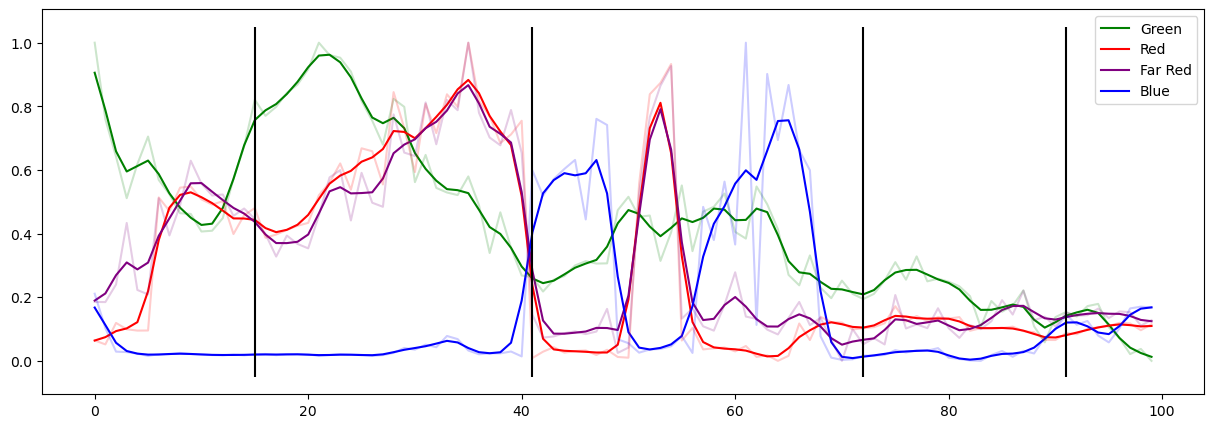

In [33]:
get_intensity_graph(single_track, smooth=1)

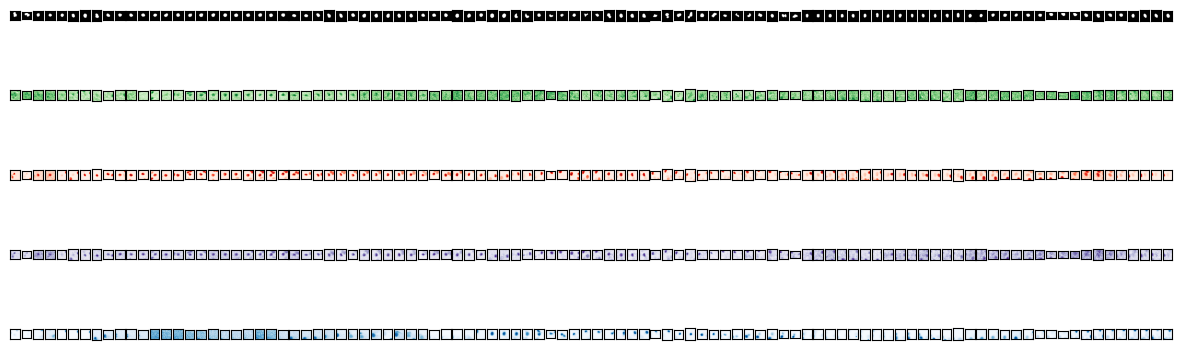

In [36]:
get_tracking_images(image, track_labels, single_track, padding=10)

In [37]:
def get_average_intensity_graph(tracks_df, graph):
    # tracks_df.loc[:, "green_intensity"] = (
    #     tracks_df["green_intensity"] - tracks_df["green_intensity"].min()
    # ) / (tracks_df["green_intensity"].max() - tracks_df["green_intensity"].min())
    # tracks_df.loc[:, "red_intensity"] = (
    #     tracks_df["red_intensity"] - tracks_df["red_intensity"].min()
    # ) / (tracks_df["red_intensity"].max() - tracks_df["red_intensity"].min())
    # tracks_df.loc[:, "farred_intensity"] = (
    #     tracks_df["farred_intensity"] - tracks_df["farred_intensity"].min()
    # ) / (tracks_df["farred_intensity"].max() - tracks_df["farred_intensity"].min())
    # if BLUE_FLAG:
    #     tracks_df.loc[:, "blue_intensity"] = (
    #         tracks_df["blue_intensity"] - tracks_df["blue_intensity"].min()
    #     ) / (tracks_df["blue_intensity"].max() - tracks_df["blue_intensity"].min())

    time_groups = tracks_df.groupby(by="t")

    tracks_df_means = time_groups.mean(numeric_only=True)
    tracks_df_std = time_groups.std(numeric_only=True)
    tracks_df_len = time_groups.count()

    Z_SCORE = 1.96

    plt.plot(
        tracks_df_means.index,
        tracks_df_means["green_intensity"],
        label="Gree",
        color="green",
    )
    plt.fill_between(
        tracks_df_means.index,
        tracks_df_means["green_intensity"]
        - Z_SCORE
        * tracks_df_std["green_intensity"]
        / tracks_df_len["green_intensity"].pow(0.5),
        tracks_df_means["green_intensity"]
        + Z_SCORE
        * tracks_df_std["green_intensity"]
        / tracks_df_len["green_intensity"].pow(0.5),
        alpha=0.2,
        color="green",
    )
    plt.plot(
        tracks_df_means.index,
        tracks_df_means["red_intensity"],
        label="Red",
        color="red",
    )
    plt.fill_between(
        tracks_df_means.index,
        tracks_df_means["red_intensity"]
        - Z_SCORE
        * tracks_df_std["red_intensity"]
        / tracks_df_len["red_intensity"].pow(0.5),
        tracks_df_means["red_intensity"]
        + Z_SCORE
        * tracks_df_std["red_intensity"]
        / tracks_df_len["red_intensity"].pow(0.5),
        alpha=0.2,
        color="red",
    )
    plt.plot(
        tracks_df_means.index,
        tracks_df_means["farred_intensity"],
        label="Far Red",
        color="purple",
    )
    plt.fill_between(
        tracks_df_means.index,
        tracks_df_means["farred_intensity"]
        - Z_SCORE
        * tracks_df_std["farred_intensity"]
        / tracks_df_len["farred_intensity"].pow(0.5),
        tracks_df_means["farred_intensity"]
        + Z_SCORE
        * tracks_df_std["farred_intensity"]
        / tracks_df_len["farred_intensity"].pow(0.5),
        alpha=0.2,
        color="purple",
    )

    if BLUE_FLAG:
        plt.plot(
            tracks_df_means.index,
            tracks_df_means["blue_intensity"],
            label="Blue",
            color="blue",
        )
        plt.fill_between(
            tracks_df_means.index,
            tracks_df_means["blue_intensity"]
            - Z_SCORE
            * tracks_df_std["blue_intensity"]
            / tracks_df_len["blue_intensity"].pow(0.5),
            tracks_df_means["blue_intensity"]
            + Z_SCORE
            * tracks_df_std["blue_intensity"]
            / tracks_df_len["blue_intensity"].pow(0.5),
            alpha=0.2,
            color="blue",
        )
    plt.legend()
    plt.show()

In [38]:
def get_average_offset_intensity_graph(tracks_df, graph):
    """Get the average intensity over all tracks with time
            offset to the last split for each track.
        Intensities are normalized over their track.

        Skip the tracks which do not split.

    Args:
            tracks_df (pd.DataFrame): DataFrame of all tracks
            graph (dict): dictionary generated from ultrack
                    with track hiearchy.
    """
    offset_df = pd.DataFrame(columns=tracks_df.columns)
    for single_track in get_lines(tracks_df, graph):
        last_split_time = 0
        lines = single_track["track_id"].unique()

        single_track.loc[:, "green_intensity"] = (single_track["green_intensity"] - single_track["green_intensity"].min()) / (single_track["green_intensity"].max() - single_track["green_intensity"].min())
        single_track.loc[:, "red_intensity"] = (single_track["red_intensity"] - single_track["red_intensity"].min()) / (single_track["red_intensity"].max() - single_track["red_intensity"].min())
        single_track.loc[:, "farred_intensity"] = (single_track["farred_intensity"] - single_track["farred_intensity"].min()) / (single_track["farred_intensity"].max() - single_track["farred_intensity"].min())
        if BLUE_FLAG:
            single_track.loc[:, "blue_intensity"] = (single_track["blue_intensity"] - single_track["blue_intensity"].min()) / (single_track["blue_intensity"].max() - single_track["blue_intensity"].min())

        for line_idx in lines:
            line = single_track[single_track["track_id"] == line_idx]
            if min(line.t) > last_split_time:
                last_split_time = min(line["t"])

        if last_split_time > 0:
            single_track.loc[:, "t"] = single_track["t"].sub(last_split_time)
            offset_df = pd.concat([offset_df, single_track])

    time_groups = offset_df.groupby(by="t")

    offset_df_means = time_groups.mean(numeric_only=True)
    offset_df_std = time_groups.std(numeric_only=True)
    offset_df_len = time_groups.count()

    Z_SCORE = 1.96

    plt.plot(
        offset_df_means.index,
        offset_df_means["green_intensity"],
        label="Green",
        color="green",
    )
    plt.fill_between(
        offset_df_means.index,
        offset_df_means["green_intensity"]
        - Z_SCORE
        * offset_df_std["green_intensity"]
        / offset_df_len["green_intensity"].pow(0.5),
        offset_df_means["green_intensity"]
        + Z_SCORE
        * offset_df_std["green_intensity"]
        / offset_df_len["green_intensity"].pow(0.5),
        alpha=0.2,
        color="green",
    )
    plt.plot(
        offset_df_means.index,
        offset_df_means["red_intensity"],
        label="Red",
        color="red",
    )
    plt.fill_between(
        offset_df_means.index,
        offset_df_means["red_intensity"]
        - Z_SCORE
        * offset_df_std["red_intensity"]
        / offset_df_len["red_intensity"].pow(0.5),
        offset_df_means["red_intensity"]
        + Z_SCORE
        * offset_df_std["red_intensity"]
        / offset_df_len["red_intensity"].pow(0.5),
        alpha=0.2,
        color="red",
    )
    plt.plot(
        offset_df_means.index,
        offset_df_means["farred_intensity"],
        label="Far Red",
        color="purple",
    )
    plt.fill_between(
        offset_df_means.index,
        offset_df_means["farred_intensity"]
        - Z_SCORE
        * offset_df_std["farred_intensity"]
        / offset_df_len["farred_intensity"].pow(0.5),
        offset_df_means["farred_intensity"]
        + Z_SCORE
        * offset_df_std["farred_intensity"]
        / offset_df_len["farred_intensity"].pow(0.5),
        alpha=0.2,
        color="purple",
    )

    if BLUE_FLAG:
        plt.plot(
            offset_df_means.index,
            offset_df_means["blue_intensity"],
            label="Blue",
            color="blue",
        )
        plt.fill_between(
            offset_df_means.index,
            offset_df_means["blue_intensity"]
            - Z_SCORE
            * offset_df_std["blue_intensity"]
            / offset_df_len["blue_intensity"].pow(0.5),
            offset_df_means["blue_intensity"]
            + Z_SCORE
            * offset_df_std["blue_intensity"]
            / offset_df_len["blue_intensity"].pow(0.5),
            alpha=0.2,
            color="blue",
        )
        
    top, bottom = plt.ylim()
    plt.vlines(
        0,
        ymin=top,
        ymax=bottom,
        color="black",
    )
    plt.legend()
    plt.xlim(left=-25)
    plt.show()

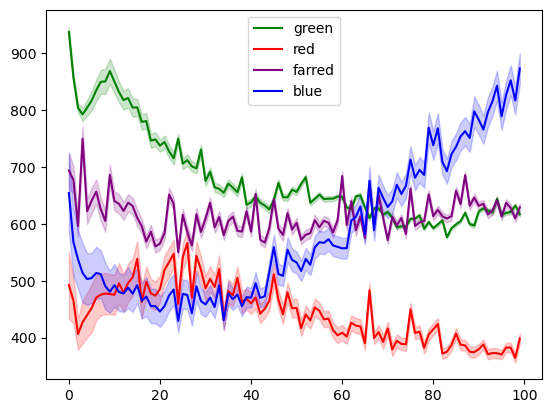

In [39]:
get_average_intensity_graph(track_intensity_df, graph)

/tmp/ipykernel_21889/3197323065.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  offset_df = pd.concat([offset_df, single_track])


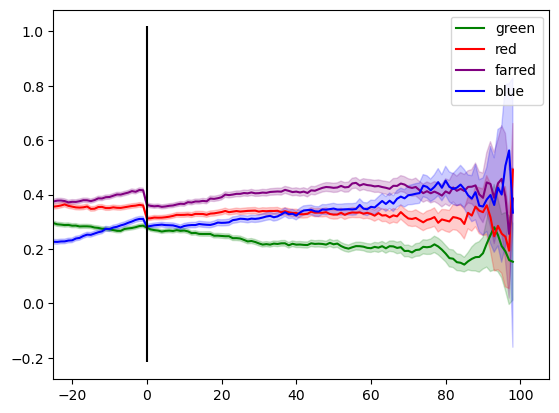

In [40]:
get_average_offset_intensity_graph(track_intensity_df, graph)

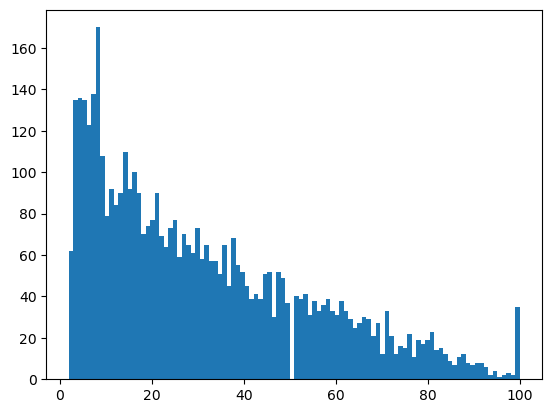

In [96]:
last_line_lengths = []
for single_track in get_lines(tracks_df, graph):
	last_split_time = 0
	last_line_idx = single_track.iloc[0]["track_id"]
	lines = single_track.track_id.unique()

	for line_idx in lines:
		line = single_track[single_track["track_id"] == line_idx]
		if min(line.t) > last_split_time:
			last_split_time = min(line.t)
			last_line_idx = line_idx
	
	last_line = single_track[single_track["track_id"] == last_line_idx]
	if len(last_line) == 0:
		print(single_track)
	last_line_lengths.append(len(last_line))
plt.hist(last_line_lengths, bins=100)
plt.show()

In [92]:
min(last_line_lengths)

0